To do:
1. Structure the class encoder and ConvCNP better: Allow for variable CNN to be defined
(Is it necessary that the height and width of output feature map is the same the input height and width? Otherwise,
it gets a mess)
2. Change the architecture such that it allows for minibatches of data sets (so far only: minibatch size is one)
3. Show in an example with plot that equivariance is not fulfilled (maybe one before training, one after traing)


In [1]:
#LIBRARIES:
#Tensors:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils


#Plotting in 2d/3d:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
from matplotlib.colors import Normalize
import matplotlib.cm as cm
%matplotlib inline

#Own files:
import Kernel_and_GP_tools as GP
import My_Tools

In [2]:
#HYPERPARAMETERS:
#Set default as double:
torch.set_default_dtype(torch.double)

In [3]:
class ConvCNP_Encoder(nn.Module):
    def __init__(self, dim_X, x_range,y_range=None,kernel_type="rbf",n_x_axis=10,n_y_axis=None):
        super(ConvCNP_Encoder, self).__init__()
        '''
        Inputs:
            dim_X: int - dimension of state space
            x_range,y_range: float lists of size 2 - give range of grid points at x-axis/y-axis
            kernel_type: string - type of kernel to use for embedding
            n_x_axis: int - number of grid points along the x-axis
            n_y_axis: int - number of grid points along the y-axis
        '''
        self.dim_X=dim_X
        self.dim_Y=2
        self.kernel_type=kernel_type
        self.x_range=x_range
        self.n_x_axis=n_x_axis

        #If y_range is None set to the same as x_range:
        if y_range is not None:
            self.y_range=y_range
        else:
            self.y_range=x_range
        #If n_y_axis is None set to the same as n_y_axis:
           
        if n_y_axis is not None:
            self.n_y_axis=n_y_axis
        else:
            self.n_y_axis=n_x_axis
            
        #Create a flattened grid: Periodic grid is y-axis - repetitive grid is x-axis
        #i.e. self.grid[k*n_y_axis+j] corresponds to unflattended Grid[k][j]
        self.grid=My_Tools.Give_2d_Grid(min_x=self.x_range[0],max_x=self.x_range[1],
                               min_y=self.y_range[0],max_y=self.y_range[1],
                               n_x_axis=self.n_x_axis,n_y_axis=self.n_y_axis,flatten=True)
        
    #This is the function y->(1,y,y^2,y^3,...,y^n) in the ConvCNP paper - for now it just adding a one to every y: y->(1,y):
    def Psi(self,Y):
        '''
        Input: Y - torch.tensor - shape (n,2)
        Output: torch.tensor -shape (n,3) - added a column of ones to Y (at the start, i.e. row 0)
        '''
        return(torch.cat((torch.ones(Y.size(0)).unsqueeze(1),Y),dim=1))
        
    def forward(self,X,Y,normalize=True):
        '''
        Inputs:
            X: torch.tensor - shape (n,self.dim_X)
            Y: torch.tensor - shape (n,self.dim_Y)
            x_range: List of floats - size 2 - x_range[0] gives minimum x-grid, x_range[1] - gives maximum x-grid
            y_range: List of floats - size 2 - y_range[0] gives minimum y-grid, y_range[1] - gives maximum y-grid
                     if None: x_range is taken
            n_grid_points: int - number of grid points per dimension 
        Outputs:
            torch.tensor - shape (D,n_x_axis,n_y_axis) where D is the output dimension of D - for now: D=self.dim_Y+1
        '''
        #Compute for every grid-point x' the value k(x',x_i) for all x_i in the data 
        #i.e. compute the matrix k(Grid,X):
        Gram=GP.Gram_matrix(self.grid,X,kernel_type=self.kernel_type,B=torch.ones((1)))
        #Note Gram[k*n_y_axis+j,l]=k(Grid[k,j],X[l])
        
        #Compute feature expansion:
        Expand_Y=self.Psi(Y)
        #Compute feature map - get shape (n_x_axis*n_y_axis,3)
        Feature_Map=torch.mm(Gram,Expand_Y)
        
        #If wanted, normalize the weights for the channel which is not the density channel:
        if normalize:
            #Normalize the functional representation:
            Feature_Map[:,1:]=Feature_Map[:,1:]/torch.sum(Gram,1).view(-1,1)
        
        #Reshape the Feature Map to the form (n_channels=3,n_y_axis,n_x_axis) (because this is the form required for a CNN):
        return(Feature_Map.view(self.n_x_axis,self.n_y_axis,Expand_Y.size(1)).permute(dims=(2,1,0)))
        

In [4]:
#A class which defines a ConvCNP:
#Still to do:
#1. Define a training function 
#2. Allow for a variable CNN (the CNN used so far is fixed)
class ConvCNP(nn.Module):
    def __init__(self,decoder, x_range,y_range=None,kernel_type="rbf",n_x_axis=10,n_y_axis=None):
        '''
        Inputs:
            x_range,y_range,kernel_type,n_x_axis,n_y_axis: see ConvCNP_Encoder            
        '''
        
        super(ConvCNP, self).__init__()
        self.encoder=ConvCNP_Encoder(2,x_range,y_range,kernel_type,n_x_axis,n_y_axis)
        #Decoder: For now: A standard CNN whose parameters are arbitrary for now:
        self.decoder=decoder
        
    #Define the forward pass of ConvCNP: 
    def forward(self,X_context,Y_context,X_Target):
        '''
        Inputs:
            X_context: torch.tensor - shape (n_context,2)
            Y_context: torch.tensor - shape (n_context,2)
            X_target: torch.tensor - shape (n_target,2)
        Outputs:
            Means_target: torch.tensor - shape (n_target,2) - mean of predictions
            Vars_target: torch.tensor -shape (n_target,2) - var of predictions
        '''
        #1.Context Set -> Embedding (via Encoder):
        Embedding=self.encoder(X_context,Y_context)
        #2.Embedding ->Feature Map (via CNN):
        Final_Feature_Map=self.decoder(Embedding.unsqueeze(0)).squeeze()
        #Split into mean and variance and "make variance positive":
        Means_grid=Final_Feature_Map[:2]
        Vars_grid=torch.log(1+torch.exp(Final_Feature_Map[2:]))
        
        #Reshape from (2,n_y_axis,n_x_axis) to (n_x_axis*n_y_axis,2) 
        Means_grid=Means_grid.permute(dims=(2,1,0))
        Means_grid=Means_grid.reshape(self.encoder.n_x_axis*self.encoder.n_y_axis,2)
        Vars_grid=Vars_grid.permute(dims=(2,1,0))
        Vars_grid=Vars_grid.reshape(self.encoder.n_x_axis*self.encoder.n_y_axis,2)
        
        #3.Feature Map -> Predictions on Target Set (via Kernel smoothing)
        #Compute covariance matrix K(X_Target,Grid) - gives the weights for predictions:
        Gram_Target=GP.Gram_matrix(X_Target,self.encoder.grid,kernel_type=self.encoder.kernel_type,B=torch.ones((1)))
        Means_target=torch.mm(Gram_Target,Means_grid)
        Vars_target=torch.mm(Gram_Target,Vars_grid)
        return(Means_target, Vars_target)
    
    def plot_Context_Target(self,X_Context,Y_Context,X_Target,Y_Target=None):
        '''
            Inputs: X_Context, Y_Context, X_Target: torch.tensor - see self.forward
                    Y_Target: torch.tensor - shape (n_context_points,2) - ground truth
            Output: None - plots predictions
        
        '''
        #Get predictions:
        Means,Vars=self.forward(X_Context,Y_Context,X_Target)
        #Plot predictions against ground truth:
        My_Tools.Plot_Inference_2d(X_Context,Y_Context,X_Target,Y_Target,Predict=Means.detach(),Vars=Vars.detach())
    
    def loss(self,Y_Target,Predict,Vars):
        '''
            Inputs: X_Target,Y_Target: torch.tensor - shape (n,2) - Target set locations and vectors
                    Predict: torch.tensor - shape (n,2) - Predictions of Y_Target at X_Target
            Output: -log_ll: log_ll is the log-likelihood at Y_Target given the parameters Predict as means and Vars as variances
        '''
        dist_tuple=torch.distributions.normal.Normal(loc=Predict,scale=torch.sqrt(Vars))
        log_ll=dist_tuple.log_prob(Y_Target).mean()
        return(-log_ll)

In [12]:
class ConvCNP_Operator(nn.Module):
    def __init__(self,ConvCNP,data_loader,Max_n_context_points,n_epochs=10,
                 learning_rate=1e-3,n_prints=None, n_plots=None,weight_decay=0.0,n_iterat_per_epoch=10):
        super(ConvCNP_Operator, self).__init__()
        '''
        Input: 
          ConvCNP: ConvCNP Module (see above)

          data_loader: torch.utils.data.DataLoader
                       every minibatch is a list of length 2 with 
                       1st element: data features - torch.tensor - shape (minibatch_size,n,2)
                       2nd element: data labels   - torch.tensor - shape (minibatch_size,n,2)
          epochs: int -number of epochs for training
          learning_rate: float-learning rate for optimizer
          weight_decay: float- weight_decay for optimizer
          n_prints: int - total number of printed losses during training
          n_plots:  if int: total number of plots during training
                    if None: no plots during training
        '''

        self.ConvCNP=ConvCNP
        self.n_epochs=n_epochs
        self.learning_rate=learning_rate
        if n_prints is None:
            self.n_prints=n_epochs
        else:
            self.n_prints=n_prints
        if n_prints is None:
            self.n_plots=n_epochs
        else:
            self.n_plots=n_plots
        self.weight_decay=weight_decay
        self.Max_n_context_points=Max_n_context_points
        self.data_loader=data_loader
        self.minibatch_size=self.data_loader.batch_size
        self.n_data_points=len(data_loader.dataset)
        self.n_grid_points=data_loader.dataset[0][0].size(0)
        self.log_ll_memory=None
        self.trained=False
        self.n_iterat_per_epoch=n_iterat_per_epoch
        
    def train(self):
        '''
        Output:
          self.ConvCNP is trained (inplace)
          log_ll_vec: torch.tensor
                      Shape (n_epochs)
                      mean log likelihood over one epoch

        Prints:
          Prints self.n_prints-times the mean loss (per minibatch) of the last epoch
        
        Plots (if n_plots is not None):
          We choose a random function and random context before training and plot the development
          of the predictions (mean of the distributions) over the training
        '''
        #Save the number of iterations the optimizer used per epoch:
        n_iterat_per_epoch=self.n_data_points//self.minibatch_size+self.data_loader.drop_last

        #Define the optimizer and add a weight decay term:
        optimizer=torch.optim.Adam(self.ConvCNP.parameters(),lr=self.learning_rate,weight_decay=self.weight_decay)

        #Track the mean loss of every epoch:
        loss_vector=torch.zeros(self.n_epochs)
        #Print the loss every "track_every" iteration:
        track_every=self.n_epochs//self.n_prints        
        
        #Show plots or not? 
        show_plots=(self.n_plots is not None)
        
        #If yes: pick a random function from the data loader and choose a random subset
        #of context points by saving their indices:
        if show_plots:
            plot_every=self.n_epochs//self.n_plots

            #Get a random function:
            Plot_X,Plot_Y=next(iter(self.data_loader))
            #Number of context points is expected number of context points:
            n_context_points=self.Max_n_context_points//2
            
            #Split:
            Plot_x_context,Plot_y_context,Plot_x_target,Plot_y_target=My_Tools.Rand_Target_Context_Splitter(Plot_X.squeeze(),
                                                                                   Plot_Y.squeeze(),
                                                                                   n_context_points)
        
        for epoch in range(self.n_epochs):
            loss_epoch_mean=0.0
            for i in range(self.n_iterat_per_epoch):
                features, labels=next(iter(self.data_loader))
                #Set the loss to zero:
                loss=torch.tensor(0.0) 

                #Sample the number of context points uniformly: 
                n_context_points=torch.randint(size=[],low=2,high=self.Max_n_context_points)
                
                x_context,y_context,x_target,y_target=My_Tools.Rand_Target_Context_Splitter(features.squeeze(),
                                                                                   labels.squeeze(),
                                                                                   n_context_points)
                
                Means,Vars=self.ConvCNP(x_context,y_context,x_target)
                loss=self.ConvCNP.loss(y_target,Means,Vars)
                #Set gradients to zero:
                optimizer.zero_grad()
                #Compute gradients:
                loss.backward()

                #Perform optimization step:
                optimizer.step()
                loss_epoch_mean=loss_epoch_mean+loss.detach().item()/n_iterat_per_epoch
            #Track the loss:
            if (epoch%track_every==0):
                print("Epoch: ",epoch," | Loss: ", loss_epoch_mean)
            
            if show_plots:
                if (epoch%plot_every==0):
                    self.ConvCNP.plot_Context_Target(Plot_x_context,Plot_y_context,Plot_x_target,Plot_y_target)
            
            #Save loss and compute gradients:
            loss_vector[epoch]=loss_epoch_mean
        
        self.log_ll_memory=-loss_vector.detach().numpy()
        
        #Set trained to True:
        self.trained=True
        #Return the mean log-likelihood:
        return(self.log_ll_memory)
    
    #A function which tests the ConvCNP by plotting the predictions:
    def test(self,n_samples=4,compare_with_GP=False):
        for i in range(n_samples):
            plt.figure(plt.gcf().number+1)
            X,Y=next(iter(self.data_loader))
            n_context_points=torch.randint(size=[],low=2,high=self.Max_n_context_points)
            x_context,y_context,x_target,y_target=My_Tools.Rand_Target_Context_Splitter(X.squeeze(),
                                                                                   Y.squeeze(),
                                                                                   n_context_points)
            self.ConvCNP.plot_Context_Target(x_context,y_context,x_target,y_target)
            if compare_with_GP:
                plt.figure(plt.gcf().number+1)
                Means_GP,Cov_Mat_GP,Vars_GP=GP.GP_inference(x_context,y_context,x_target, kernel_type=self.ConvCNP.encoder.kernel_type)
                My_Tools.Plot_Inference_2d(x_context,y_context,x_target,y_target,Predict=Means_GP,Vars=Vars_GP)


In [13]:
GP_data_loader=GP.load_2d_GP_data(Id="88499")

In [14]:
decoder=nn.Sequential(nn.Conv2d(3,5,kernel_size=5,stride=1,padding=2),
              nn.ReLU(),
                nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
              nn.Conv2d(5,8,kernel_size=7,stride=1,padding=3),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
              nn.Conv2d(8,4,kernel_size=5,stride=1,padding=2))
#Create a Test ConvCNP:
Convolut_CNP=ConvCNP(decoder,x_range=[-2,2],y_range=[-2,2],n_x_axis=30,n_y_axis=30)

In [15]:
Convolut_CNP_Operator=ConvCNP_Operator(Convolut_CNP,data_loader=GP_data_loader,Max_n_context_points=100,n_epochs=1,n_plots=10,n_iterat_per_epoch=2)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

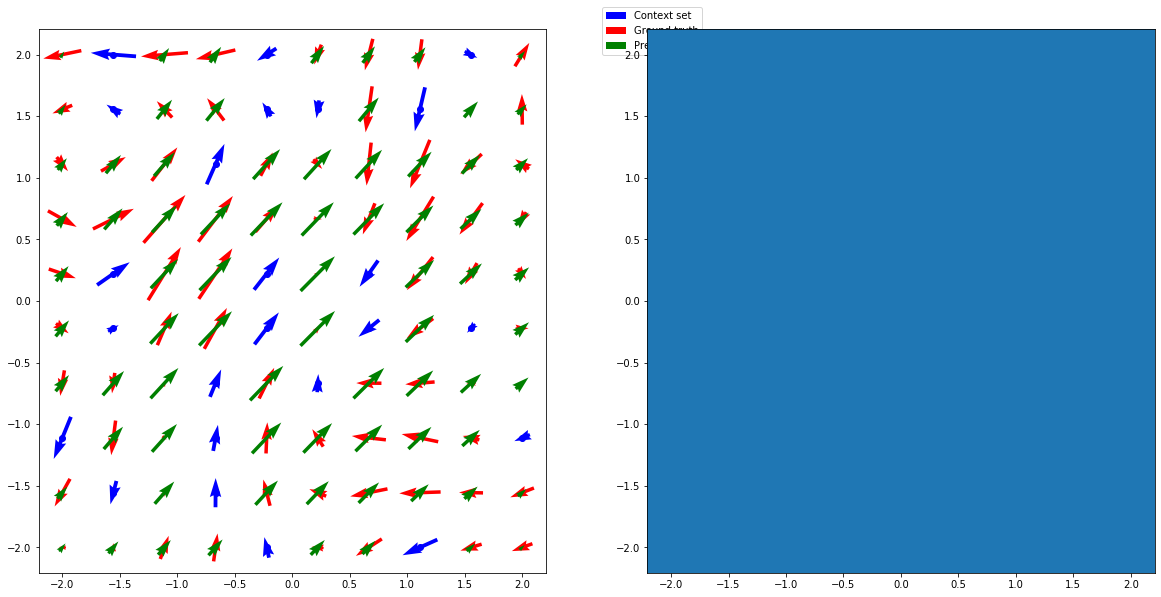

<Figure size 432x288 with 0 Axes>

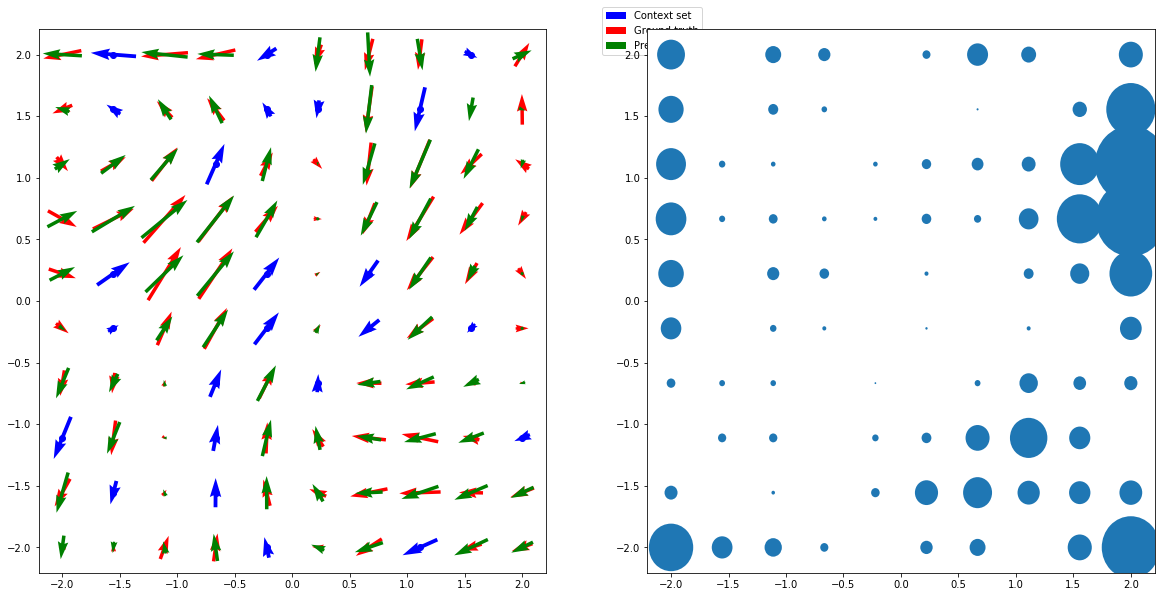

In [16]:
Convolut_CNP_Operator.test(n_samples=1,compare_with_GP=True)